# Exploratory Data Analysis

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#Import dataset and reset index
train_df = pd.read_excel("../data/external/pizza_training_data.xlsx")
#train_df = pd.read_excel('pizza_training_data.xlsx', parse_dates=['order_date'])
train_df.set_index('Unnamed: 0', inplace = True)
train_df.index.name = ''
train_df['pizza_name'] = train_df['pizza_name'].str.replace(' Pizza', '') #Removes the word 'Pizza' from the name because it's redundant in plots
train_df['pizza_name'] = train_df['pizza_name'].str.replace('The ', '') #Removes the word 'The' from the name because it's redundant in plots


#convert order_time to datetime object
def convert_time(time_str):
    return pd.to_datetime(time_str, format='%H:%M:%S').time()

train_df['order_time'] = train_df['order_time'].apply(convert_time)

In [6]:
train_df['pizza_size'].value_counts()
train_df['pizza_name'].value_counts()
train_df['pizza_category'].value_counts()
train_df.groupby('pizza_category')['pizza_size'].value_counts()
train_df.head()

,order_details_id,order_id,pizza_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
,,,,,,,,,,,,
26975,26976,11871,pep_msh_pep_s,1,2015-07-17,20:29:22,11.00,11.00,S,Classic,"Pepperoni, Mushrooms, Green Peppers","Pepperoni, Mushroom, and Peppers"
20551,20552,9032,southw_ckn_m,1,2015-06-01,11:47:49,16.75,16.75,M,Chicken,"Chicken, Tomatoes, Red Peppers, Red Onions, Ja...",Southwest Chicken
45496,45497,19984,hawaiian_s,1,2015-12-06,13:17:15,10.50,10.50,S,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",Hawaiian
4132,4133,1837,bbq_ckn_m,1,2015-01-31,20:56:35,16.75,16.75,M,Chicken,"Barbecued Chicken, Red Peppers, Green Peppers,...",Barbecue Chicken
15752,15753,6915,spin_pesto_s,1,2015-04-26,17:57:44,12.50,12.50,S,Veggie,"Spinach, Artichokes, Tomatoes, Sun-dried Tomat...",Spinach Pesto


### Determine percentage of pizza sizes ordered for each pizza category

In [7]:
#Break into orders by size and orders by category
size_counts = train_df.groupby(['pizza_category', 'pizza_size']).size().reset_index(name='count') #breaks down S,M,L pizza size based on pizza category
category_counts = train_df['pizza_category'].value_counts() #Counts how many pizza orders in each category

#Merge the datasets into one dataset to calculate the fraction
merged_df = size_counts.merge(category_counts.rename('total_count'), left_on='pizza_category', right_index=True)
merged_df['fraction'] = (merged_df['count']/merged_df['total_count']).round(3)
merged_df

,pizza_category,pizza_size,count,total_count,fraction
0,Chicken,L,1486,3282,0.453
1,Chicken,M,1134,3282,0.346
2,Chicken,S,662,3282,0.202
3,Classic,L,1175,4295,0.274
4,Classic,M,1237,4295,0.288
5,Classic,S,1710,4295,0.398
6,Classic,XL,164,4295,0.038
7,Classic,XXL,9,4295,0.002
8,Supreme,L,1329,3584,0.371
9,Supreme,M,1240,3584,0.346


### Plot pizza orders over a 24 hr time period

In [8]:
train_df['order_time_hour'] = train_df['order_time'].apply(lambda x: x.hour + x.minute/60)

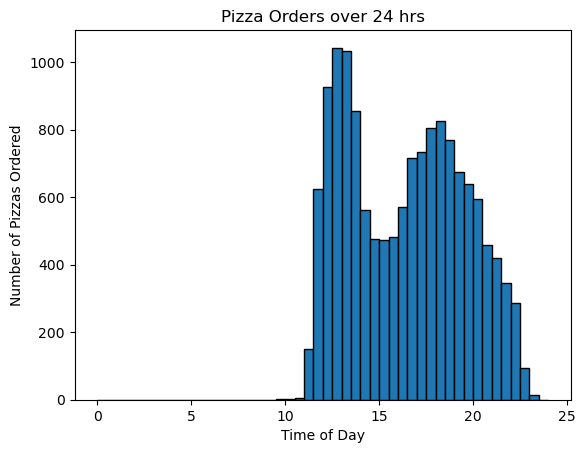

In [9]:
plt.hist(train_df['order_time_hour'], bins=48, edgecolor = 'black', range = (0,24))  
plt.xlabel('Time of Day')
plt.ylabel('Number of Pizzas Ordered')
plt.title('Pizza Orders over 24 hrs')
plt.show()

### Plot pizza orders over the year

In [10]:
train_df['day_of_year'] = train_df['order_date'].dt.dayofyear

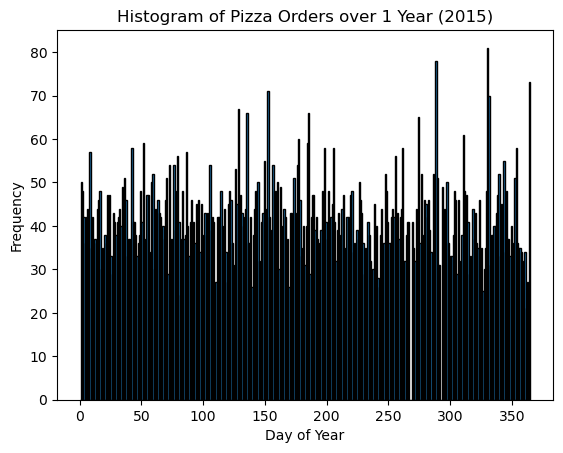

In [11]:
plt.hist(train_df['day_of_year'], bins=365, edgecolor = 'black', range = (0,365))  
plt.xlabel('Day of Year')
plt.ylabel('Frequency')
plt.title('Histogram of Pizza Orders over 1 Year (2015)')
plt.show()

### Plot pizza orders by day of week

In [12]:
train_df['day_of_week'] = train_df['order_date'].dt.dayofweek

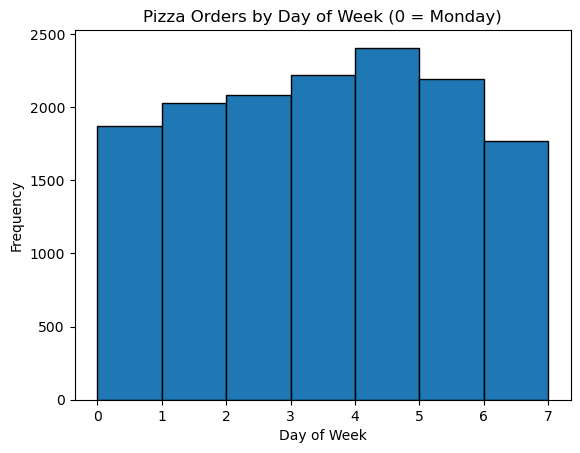

In [13]:
plt.hist(train_df['day_of_week'], bins=7, edgecolor = 'black', range = (0,7))  
plt.xlabel('Day of Week')
plt.ylabel('Frequency')
plt.title('Pizza Orders by Day of Week (0 = Monday)')
plt.show()

### Plot heat map of pizza name and pizza size

In [14]:
#group the data by pizza name and size, then pivot it to heat map
grouped_df = train_df.groupby(['pizza_name', 'pizza_size']).size().reset_index(name = 'count')
pivot_df = grouped_df.pivot(index = 'pizza_name', columns='pizza_size', values='count')


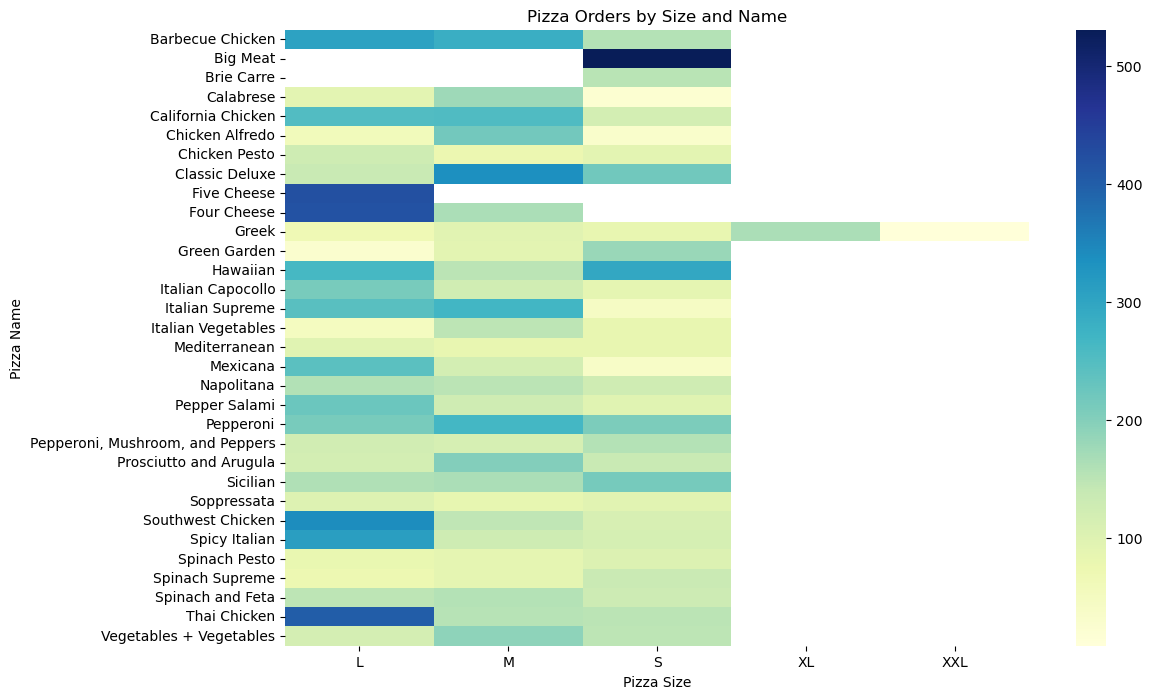

In [15]:
# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_df, cmap='YlGnBu', annot=False)
plt.title('Pizza Orders by Size and Name')
plt.xlabel('Pizza Size')
plt.ylabel('Pizza Name')
plt.show()

### Plot heat map of pizza type ordered by season

In [16]:
#Add a season category (places into Q1, Q2, Q3, or Q4)
def get_season(month):
    if month in [1, 2, 3]:
        return 'Q1'
    elif month in [4, 5, 6]:
        return 'Q2'
    elif month in [7, 8, 9]:
        return 'Q3'
    else:
        return 'Q4'

train_df['quarter'] = train_df['order_date'].dt.month.apply(get_season)

In [17]:
#group the data by pizza name and quarter, then pivot it to heat map
grouped_df = train_df.groupby(['pizza_name', 'quarter']).size().reset_index(name = 'count')
pivot_df = grouped_df.pivot(index = 'pizza_name', columns='quarter', values='count')


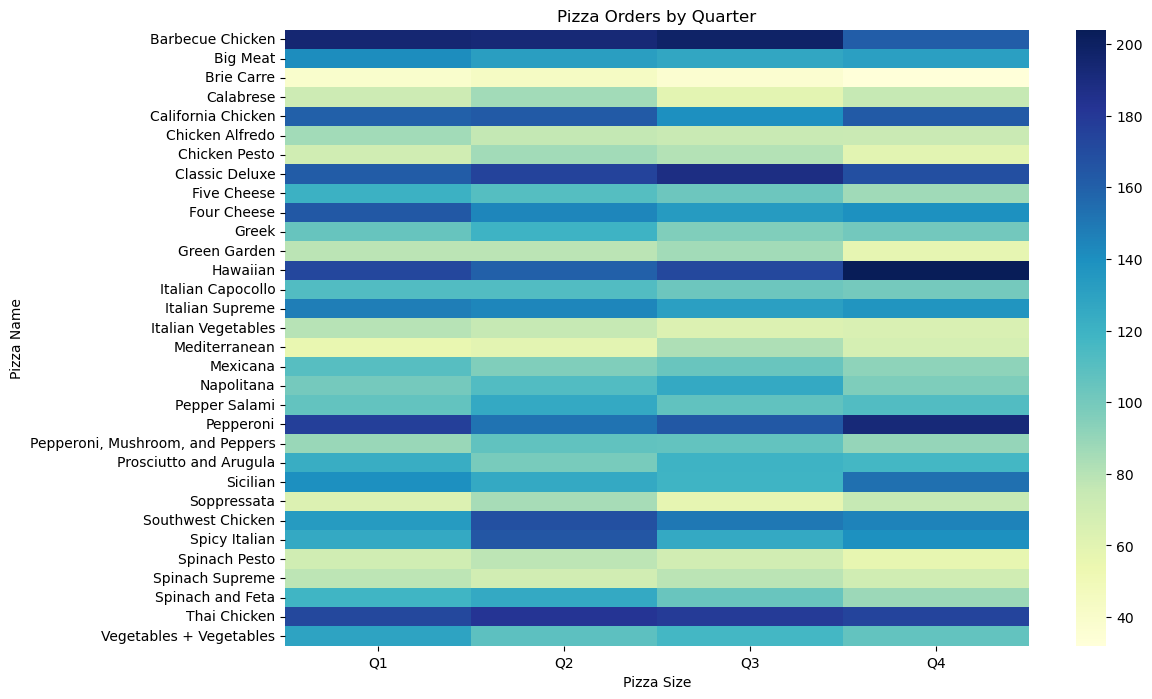

In [21]:
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_df, cmap='YlGnBu', annot=False)
plt.title('Pizza Orders by Quarter')
plt.xlabel('Pizza Size')
plt.ylabel('Pizza Name')
plt.show()

### Plot yearly revenue by pizza type

In [22]:
#total_price = unit_price * quantity, so total price captures all $ spend on that pizza
sales = train_df.groupby('pizza_name')['total_price'].sum().sort_values(ascending=False)

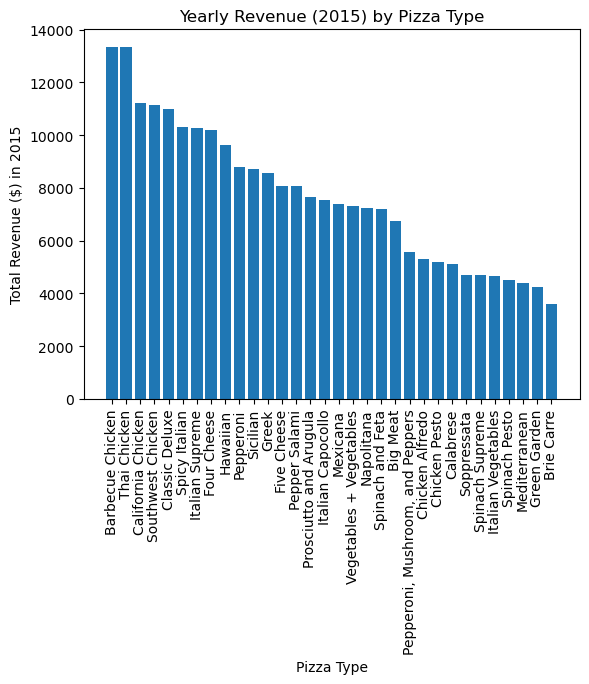

In [23]:
plt.bar(x = sales.index, height = sales.values)
plt.xlabel('Pizza Type')
plt.ylabel('Total Revenue ($) in 2015')
plt.title('Yearly Revenue (2015) by Pizza Type')
plt.xticks(rotation=90)
plt.show()

### Plot sales as a function of price (Note: all pizza sizes averaged to one price.  Need to redo this section)

In [319]:
#Make a sales series and reset index
sales = train_df.groupby('pizza_name')['total_price'].sum().sort_values(ascending=False)
sales = sales.reset_index(name = 'revenue')

#make a pizza price series and reset index
pizza_price = train_df.groupby('pizza_name')['unit_price'].mean()
pizza_price = pizza_price.reset_index(name = 'avg_price')

#merge df into one larger df
merged_sales_df = pd.merge(sales, pizza_price, on = 'pizza_name', how = 'left')

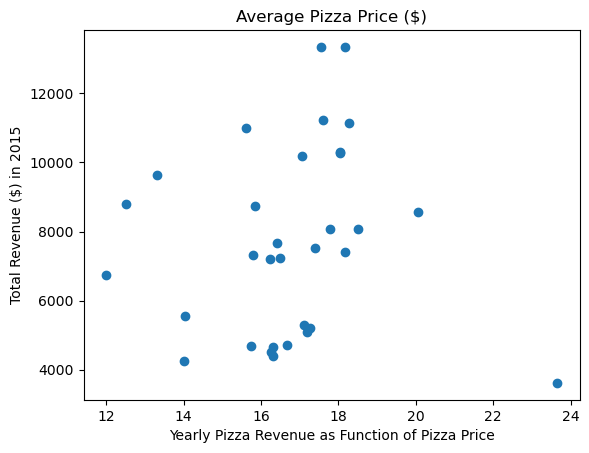

In [318]:
plt.scatter(x = merged_sales_df['avg_price'], y = merged_sales_df['revenue'])
plt.xlabel('Yearly Pizza Revenue as Function of Pizza Price')
plt.ylabel('Total Revenue ($) in 2015')
plt.title('Average Pizza Price ($)')
plt.show()